# Project 2 : Medical Image Classification
by: Zeynep Turk and Amoreena Ordoñez

In this project we will be training supervised and unsupervised machine learning models for image classification using the Chest X-Rays dataset compiled by the Naional Institutes of Health. The original set contains 112,120 images in 1024 x 1024 pixel resolution and patient data with class labels of disease type for each observation. For our use we'll import a previously created random 5% sample containing 5,606 of the images. The class labels are as follows:

* Atelectasis
* Cardiomegaly
* Consolidation
* Edema
* Effusion
* Emphysema
* Fibrosis
* Hernia
* Infiltration
* Nodule Mass
* No Findings
* Pleural Thickening
* Pneumonia
* Pneumothorax

The goal of this work is to predict a patient diagnosis based on the imaging as accurately as possible. Training and tuning such models is important work that can advance research, lead to early intervention, and guide treatment plans. To begin we will import the necessary libraries as well as the dataset files.

In [95]:
## import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import os
import glob

import seaborn as sns

In [13]:
pip install opendatasets

In [14]:
## import dataset from kaggle
import opendatasets as od
od.download("https://www.kaggle.com/datasets/nih-chest-xrays/sample?select=sample")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: amoreenaordoez
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample


100%|██████████| 4.20G/4.20G [00:42<00:00, 107MB/s]


In [103]:
# sanity check
print(os.listdir("sample"))


['sample', 'sample_labels.csv']


## Cleaning and Processing
Now that we've imported our dataset we can see it contains one csv file with recorded patient data which includes our class labels for the target variable and a folder of the .png images. Let's create a dataframe to read the .csv file into and take a look at its structure.


In [63]:
## create dataframe of patient data and verify number of observations in sample
pt_data = pd.read_csv("sample/sample_labels.csv")
pt_data.shape

(5606, 11)

In [62]:
## check the variables in our data frame and check finding labels
pt_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [67]:
## check for na values to expel from dataframe
pt_data.dropna()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


There are no missing values in this dataframe but we can see just from the few entries above that some finding labels have multiple categories in one observation. For simplicity we will use only the first label listed in each instance.

In [102]:
## simplify target categorical variable with only one label per instance
pt_data["Finding Labels"] = pt_data["Finding Labels"].apply(lambda x: x.split("|")[0])
pt_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly,1,32,055Y,F,AP,2500,2048,0.168,0.168


## Visualizing
Before we move into splitting our images and labels let's take a look at the patient demographics and diagnoses.

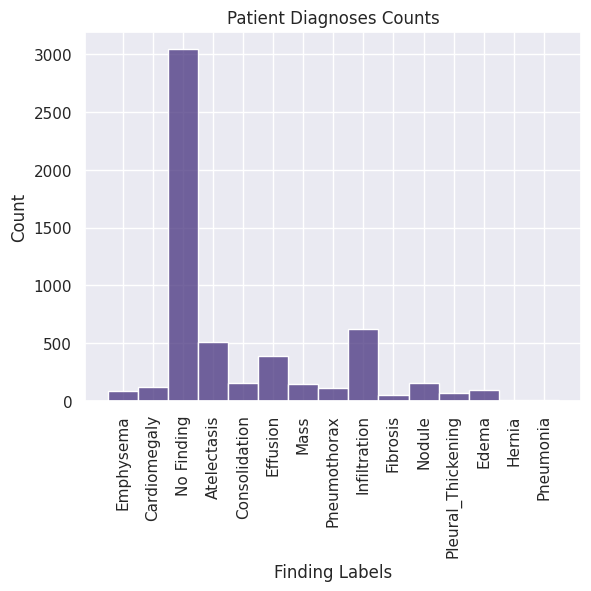

In [117]:
sns.set(style = "darkgrid", palette = "viridis")
sns.histplot(pt_data['Finding Labels'])
plt.xticks(rotation = 90)
plt.title("Patient Diagnoses Counts")
plt.show()

As we can see from this breakdown of classification labels in our dataset no finding diagnosis has a much larger count than all others. This creates an unbalanced dataset which can lead to our models showing bias towards that label and ignoring input from the rest. This is important to note since it affects our model accuracy and we will keep it in mind when choosing types of model to train, model evaluation metrics, and sampling/splitting procedures.

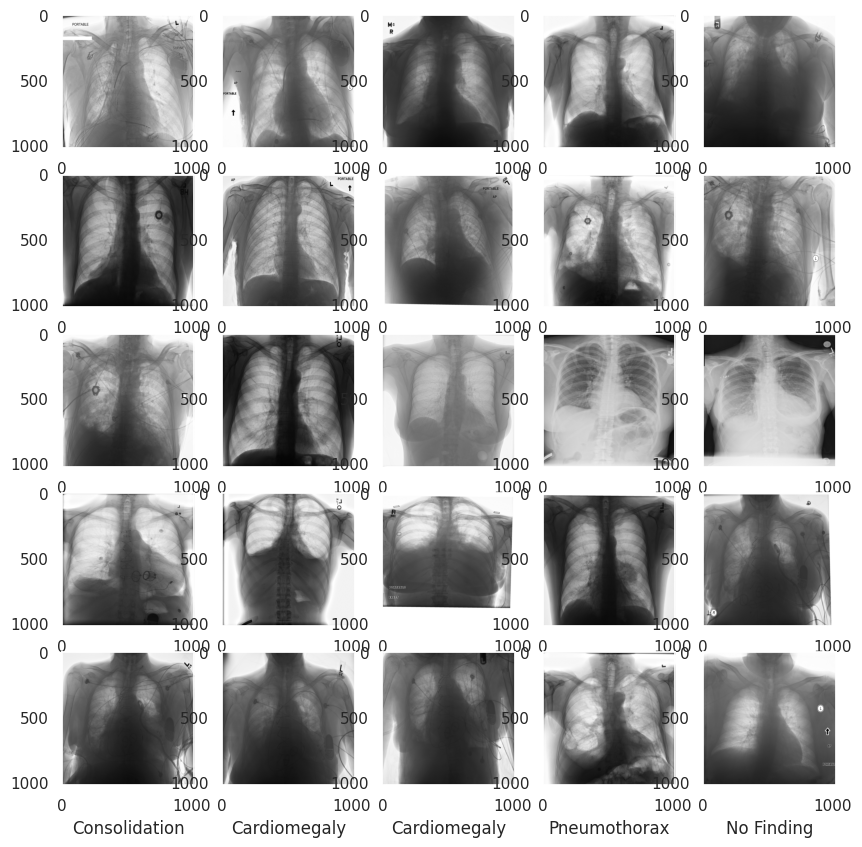

In [120]:
## plot grid of x-ray photos to see what we're working with

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.imshow(plt.imread("sample/sample/images/" + pt_data["Image Index"][i]), cmap=plt.cm.binary)
    plt.xlabel(pt_data["Finding Labels"][i])
plt.show()

## Splitting

In [84]:
## combine labels with images
labels = pt_data["Finding Labels"].to_numpy()
img_size = (128)

def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = np.where(labels == label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

combined = get_data("sample/sample")

FileNotFoundError: [Errno 2] No such file or directory: 'sample/sample/Emphysema|Infiltration|Pleural_Thickening|Pneumothorax'

## Unsupervised Modeling


## Supervised Modeling

## Results

### References